# simulated annealling

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
from scipy import ndimage, misc
from skimage.morphology import skeletonize
import sklearn
from sklearn import linear_model
from sklearn import model_selection 
from tqdm import tqdm
import cv2
import tifffile
import cupy as cp
import matplotlib
from cupyx.scipy import ndimage
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
import random
import time
from PIL import Image
import pickle

In [1]:
def extract_features(image, sigma, centroids):
    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()

    im_blur = ndimage.gaussian_filter(cp.array(image), sigma=sigma, mode='constant',cval=0)
    
    im_blur_norm=im_blur*sigma*cp.sqrt(np.pi)

    im_sx = ndimage.sobel(im_blur_norm, axis=1, mode='reflect')
    im_sy = ndimage.sobel(im_blur_norm, axis=0, mode='reflect')
    im_sobel=np.hypot(im_sx, im_sy)

    feats = []
   
    for centroid in centroids:
        x, y = centroid[0], centroid[1]
        density = cp.nanmean(im_blur_norm[x-75: x+75, y-75: y+75])
        grad = cp.nanmean(im_sobel[x-75: x+75, y-75: y+75])
        feats.append([density.get(), grad.get()])

    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()

    feats = np.array(feats)
    return feats


def generate_window(window_size, p, pad, seed):
    np.random.seed(seed)
    start = time.time()
    random_pattern = np.random.rand(window_size, window_size)
    binary_pattern = np.where(random_pattern < p, 1, 0)

    org_locs = np.argwhere(binary_pattern == 1)

    org_locs_scaled = org_locs*200+pad
    pattern_dim_scaled = window_size*200+2*pad
    
    centroids = []
    im = np.zeros((pattern_dim_scaled, pattern_dim_scaled))

    for y, x in org_locs_scaled:
        im[y:y+150,x:x+150] = 255
        centroids.append((y+75, x+75))
    
    return im, centroids, pattern_dim_scaled

def simulate(image, centers, window_size, std):
    nx, ny, ix = random_move(centers, window_size, std)
    
    # make new one
    test_img = np.copy(image)
    test_centers = centers.copy()
    old_x, old_y = test_centers[ix]
    test_img[old_x-75: old_x+75, old_y-75:old_y+75] = 0
    test_img[nx-75:nx+75, ny-75:ny+75] = 255
    test_centers[ix] = (nx, ny)
    
    new_score, feat_values = evaluate(test_img, test_centers)
    
    return test_img, test_centers, new_score, feat_values

def validate(cx, cy, centroids, window_size):    
    rep = np.tile(np.array([cx, cy]).reshape(-1,2), [len(centroids), 1])
    centroids_arr = np.array(centroids)
    dist = np.sqrt(np.sum((rep-centroids_arr)**2, axis = 1))
    min_dist = 2*(75*np.sqrt(2)+25)
    valid = np.all(dist > min_dist)
    
    return valid

def evaluate(im_pattern, centroids):
    feats400 = extract_features(im_pattern, 400, centroids)
    
    if len(feats400) > 0:
        density = feats400[:, 0].reshape(-1,1)
        grad = feats400[:, 1].reshape(-1,1)
        newX = np.hstack((density, grad))
        preds = rbf_svr_fit.predict(newX)
        pred_mean = np.mean(preds)
        
    return pred_mean, newX

def random_move(centers, window_size, std):
    found_valid_move = False
    newx, newy, random_index = 0, 0, 0
    
    while not found_valid_move:
        random_index = random.randint(0,len(centroids)-1)

        dx, dy = np.random.normal(0, std, 2)
        dx, dy = np.rint(dx), np.rint(dy)
        
        newx, newy = int(centers[random_index][0] + dx), int(centers[random_index][1] + dy)
        newx = out_of_bounds_check(newx, window_size)
        newy = out_of_bounds_check(newy, window_size)

        nbors = centers[:random_index] + centers[random_index+1:]
        
        found_valid_move = validate(newx, newy, nbors, window_size)
    
    return newx, newy, random_index

def out_of_bounds_check(coord, window_size):
    if coord < 100 + 75:
        coord = 175
        return coord
    elif coord > window_size - 100 - 75:
        coord = window_size - 100 - 75
        return coord
    else:
        return coord
        

def get_image(window_size, p, pad, seed):
    im, centroids, window_size = generate_window(window_size, p, pad, seed)
    while not len(centroids) > 2:
        im, centroids, window_size = generate_window(window_size, p, pad, seed)
    return im, centroids, window_size


def p_accept(t, beta):
    return t/(t+t*beta)

def backward_elim(X_iter, y, model):
    improving = True

    ctr = 0
    while improving: 
        print(ctr)
        feat_ix = list(range(X_iter.shape[1]))
        ref_error = cross_val_score(model, X_iter, y, cv = 5, scoring = "neg_mean_squared_error").mean()

        diff = 0
        min_ix = 0
        for ix in feat_ix:
            cols = feat_ix[:ix] + feat_ix[ix+1:]
            temp_df = X_iter.iloc[:, cols]
            temp_error = cross_val_score(model, temp_df, y, cv = 5, scoring = "neg_mean_squared_error").mean()
            temp_diff = ref_error - temp_error
            if temp_diff < diff:
                min_ix = ix
                diff = temp_diff
                print(diff)

        if diff == 0:
            print("nothing changed")
            improving = False
        else:
            cols = feat_ix[:min_ix] + feat_ix[min_ix+1:]
            X_iter = X_iter.iloc[:, cols]

        ctr += 1
    return X_iter

In [1]:
seeds = [3, 4, 7, 8, 11, 12]
log = []
niter = 2
std_perturb = 50
epsilon = 0
pattern_dim = 40
p = 1/16
pad = 1200

for seed in seeds:
    # save initial image
    im, centroids, window_size = get_image(pattern_dim, p, pad, seed)
    im_init = Image.fromarray(im.astype(np.uint8))
    im_init.save("init_seed_" + str(seed) + ".png")

    # train discriminator
    df = pd.read_csv("all_sigmas_df_comb.csv")
    X, y = df.iloc[:, :-4], df.iloc[:, -1] 
    svr = SVR(kernel='rbf')

    X_reduc = backward_elim(X, y, svr)
    svr = svr.fit(X_reduc, y)

    # run simulated annealing
    for i in tqdm(range(1, niter+1)):

        curr_score, old_feats = evaluate(im, centroids)

        new_im, new_centroids, new_score, new_feats = simulate(im, centroids, window_size, std_perturb)

        log.append((curr_score, old_feats, new_score, new_feats, centroids))

        if new_score - curr_score > epsilon:
            im, centroids, curr_score = new_im, new_centroids, new_score

    # save log and final image
    with open("log" + str(seed) + ".txt", "wb") as fp: 
        pickle.dump(log, fp)

    im_final = Image.fromarray(im.astype(np.uint8))
    im_final.save("final_seed_" + str(seed)+ ".png")

In [9]:
with open("log3.txt", "rb") as fp:
    b = pickle.load(fp)

In [26]:
old = [item[0] for item in log]
new = [item[3] for item in log]

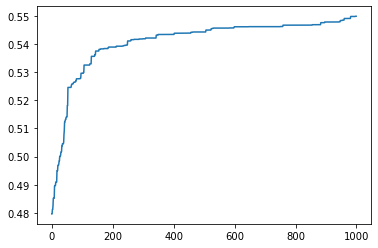

In [29]:
plt.plot(old)

(array([ 10.,  24.,  71., 110., 131., 109.,  70.,  30.,   7.,   6.]),
 array([ 3202.03821115,  5110.8544467 ,  7019.67068225,  8928.48691779,
        10837.30315334, 12746.11938889, 14654.93562443, 16563.75185998,
        18472.56809552, 20381.38433107, 22290.20056662]),
 <BarContainer object of 10 artists>)

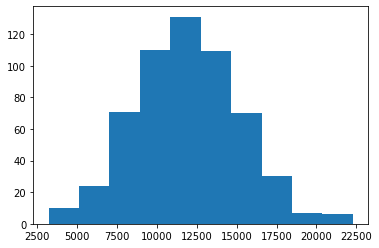

In [184]:
plt.hist(rX.density800.values)

(array([ 92., 172., 139.,  98.,  40.,  11.,   9.,   3.,   2.,   2.]),
 array([ 3975.72022746,  6201.65123481,  8427.58224216, 10653.51324951,
        12879.44425686, 15105.37526421, 17331.30627155, 19557.2372789 ,
        21783.16828625, 24009.0992936 , 26235.03030095]),
 <BarContainer object of 10 artists>)

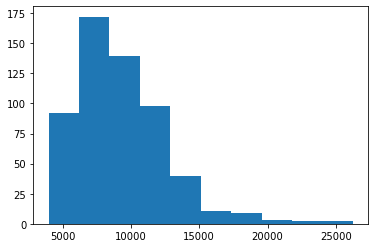

In [185]:
plt.hist(rX.density400.values)

(array([117., 174., 142.,  73.,  34.,  14.,   6.,   3.,   1.,   4.]),
 array([  8.70546594,  31.42780747,  54.150149  ,  76.87249053,
         99.59483206, 122.3171736 , 145.03951513, 167.76185666,
        190.48419819, 213.20653972, 235.92888125]),
 <BarContainer object of 10 artists>)

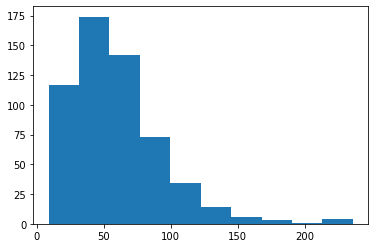

In [82]:
plt.hist(rxSub.grad_400.values)

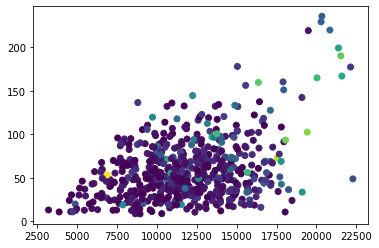

In [83]:
plt.scatter(rxSub.density_800.values, rxSub.grad_400.values, c = ry.values)

In [222]:
log

['Accepted: New score 0.1932 > old score 0.1929',
 'Rejected: New score 0.1932 <= old score 0.1932',
 'Accepted: New score 0.1933 > old score 0.1932',
 'Randomly Accepted: New score 0.1912 > old score 0.1933',
 'Accepted: New score 0.1926 > old score 0.1912',
 'Rejected: New score 0.1925 <= old score 0.1926',
 'Rejected: New score 0.1924 <= old score 0.1926',
 'Accepted: New score 0.1928 > old score 0.1926',
 'Rejected: New score 0.1925 <= old score 0.1928',
 'Randomly Accepted: New score 0.1927 > old score 0.1928',
 'Rejected: New score 0.1925 <= old score 0.1927',
 'Accepted: New score 0.1928 > old score 0.1927',
 'Randomly Accepted: New score 0.1928 > old score 0.1928',
 'Accepted: New score 0.1934 > old score 0.1928',
 'Randomly Accepted: New score 0.1931 > old score 0.1934',
 'Rejected: New score 0.1923 <= old score 0.1931',
 'Accepted: New score 0.1932 > old score 0.1931',
 'Rejected: New score 0.1929 <= old score 0.1932',
 'Accepted: New score 0.1934 > old score 0.1932',
 'Rejec

# Other

In [2]:
dfHeitorRandom = pd.read_csv("random_features_dipole_v3.csv")
rX, ry = dfHeitorRandom.iloc[:, :-1], dfHeitorRandom.iloc[:, -1]
rxSub = rX[["density800", "grad400"]]
rbf_svr = SVR(kernel='rbf')
#rbf_svr_fit = rbf_svr.fit(rxSub, ry.ravel())

scores = cross_val_score(rbf_svr, rxSub, ry, scoring="neg_mean_absolute_error")
scores.mean()

-0.10536357556116153

In [9]:
dfHeitorRandom = pd.read_csv("random_features_dipole_v3.csv")
rX, ry = dfHeitorRandom.iloc[:, :-1], dfHeitorRandom.iloc[:, -1]
rxSub = rX[["density800", "grad800"]]
rbf_svr = SVR(kernel='rbf')
#rbf_svr_fit = rbf_svr.fit(rxSub, ry.ravel())

scores = cross_val_score(rbf_svr, rxSub, ry, scoring="neg_mean_absolute_error")
scores.mean()

-0.10537079376531726

In [14]:
dfHeitorRandom = pd.read_csv("random_features_dipole_v3.csv")
rX, ry = dfHeitorRandom.iloc[:, :-1], dfHeitorRandom.iloc[:, -1]
rxSub = rX[["density600", "grad600"]]
rbf_svr = SVR(kernel='rbf')
#rbf_svr_fit = rbf_svr.fit(rxSub, ry.ravel())

scores = cross_val_score(rbf_svr, rxSub, ry, scoring="neg_mean_absolute_error")
scores.mean()

-0.10339932569552437

In [15]:
dfHeitorRandom = pd.read_csv("random_features_dipole_v3.csv")
rX, ry = dfHeitorRandom.iloc[:, :-1], dfHeitorRandom.iloc[:, -1]
rxSub = rX[["density200", "grad200"]]
rbf_svr = SVR(kernel='rbf')
#rbf_svr_fit = rbf_svr.fit(rxSub, ry.ravel())

scores = cross_val_score(rbf_svr, rxSub, ry, scoring="neg_mean_absolute_error")
scores.mean()

-0.10479019950934107

In [11]:
dfHeitorRandom = pd.read_csv("random_features_dipole_v3.csv")
rX, ry = dfHeitorRandom.iloc[:, :-1], dfHeitorRandom.iloc[:, -1]
rxSub = rX[["density400", "grad400"]]
rbf_svr = SVR(kernel='rbf')
#rbf_svr_fit = rbf_svr.fit(rxSub, ry.ravel())

scores = cross_val_score(rbf_svr, rxSub, ry, scoring="neg_mean_absolute_error")
scores.mean()

-0.10246006022261556

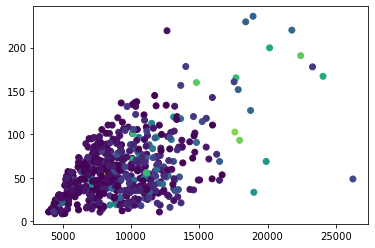

In [13]:
plt.scatter(rxSub.density400.values, rxSub.grad400.values, c = ry)

In [ ]:
def extract_features_old(image, sigma):
    #np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)
    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()
    im_8=np.uint8(image)

    edged = cv2.Canny(im_8, 30, 200)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    im_blur = ndimage.gaussian_filter(cp.array(image), sigma=sigma, mode='constant',cval=0)
    
    im_blur_norm=im_blur*sigma*cp.sqrt(np.pi)

    im_sx = ndimage.sobel(im_blur_norm, axis=1, mode='reflect')
    im_sy = ndimage.sobel(im_blur_norm, axis=0, mode='reflect')
    im_sobel=np.hypot(im_sx, im_sy)
    
    plt.imshow(im_blur.get())
    plt.show()
    plt.imshow(im_sobel.get())
    plt.show()
    
    #areas = []
    #centroids = []
    feats = []
  
    #im_lap = ndimage.gaussian_laplace(im, sigma=sigma, mode='reflect')
   
    for i in range(len(contours)):    
        im_zer = np.zeros((image.shape[0], image.shape[1]))  
        filled_array = cv2.fillPoly(im_zer, pts =[contours[i]], color=(255))
        obj = np.argwhere(filled_array == 255)

        density = cp.nanmedian(im_blur_norm[obj[:,0],obj[:,1]])
        grad = cp.nanmedian(im_sobel[obj[:,0],obj[:,1]])
        
        """M = cv2.moments(contours[i])
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append((cX, cY))
        areas.append(cv2.contourArea(contours[i]))"""
        
        feats.append([density.get(), grad.get()])

    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()

    feats = np.array(feats)
    return feats


In [142]:
pattern_dim = 40
threshold = 1/16

def generate_pattern(pattern_dim, threshold, seed):
    np.random.seed(seed)
    random_pattern = np.random.rand(pattern_dim, pattern_dim)
    binary_pattern = np.where(random_pattern < threshold, 1, 0)

    org_locs = np.argwhere(binary_pattern == 1)

    org_locs_scaled = org_locs*200+25
    centroids = []
    im = np.zeros((8000, 8000))

    for y, x in org_locs_scaled:
        im[y:y+150,x:x+150] = 255
        centroids.append((y+75, x+75))
    
    return im, centroids

big4 = []
for seed in [3, 4, 7, 8, 11, 12]:
    im, centroids = generate_pattern(pattern_dim, threshold, seed)
    n400 = extract_features(im, 400)
    big4.append(n400)

Extract features: 18.555931329727173
Extract features: 20.114577531814575
Extract features: 21.79257559776306
Extract features: 21.090495824813843
Extract features: 19.559656143188477
Extract features: 19.055235862731934


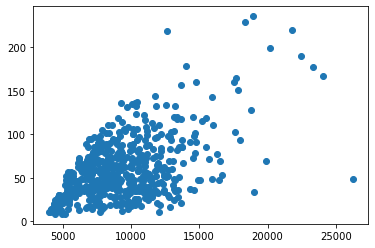

In [144]:
feats4 = [item[0] for item in big4]
centers4 = [item[1] for item in big4]
areas4 = [item[2] for item in big4]
allfeats4 = np.vstack(feats4)

plt.scatter(allfeats4[:, 0], allfeats4[:,1])

In [86]:
pattern_dim = 40
threshold = 1/16

def generate_pattern(pattern_dim, threshold, seed):
    np.random.seed(seed)
    random_pattern = np.random.rand(pattern_dim, pattern_dim)
    binary_pattern = np.where(random_pattern < threshold, 1, 0)

    org_locs = np.argwhere(binary_pattern == 1)

    org_locs_scaled = org_locs*200+25
    centroids = []
    im = np.zeros((8000, 8000))

    for y, x in org_locs_scaled:
        im[y:y+150,x:x+150] = 255
        centroids.append((y+75, x+75))
    
    return im, centroids

big = []
for seed in [3, 4, 7, 8, 11, 12]:
    im, centroids = generate_pattern(pattern_dim, threshold, seed)
    n800 = extract_features(im, 800)
    #n400 = extract_features(im, 400)
    big.append(n800)

Extract features: 22.174678564071655
Extract features: 23.710012435913086
Extract features: 25.401626586914062
Extract features: 24.719565391540527
Extract features: 23.232860326766968
Extract features: 22.736895084381104


In [94]:
feats = [item[0] for item in big]
centers = [item[1] for item in big]
areas = [item[2] for item in big]
allfeats = np.vstack(feats)

plt.scatter(allfeats[:, 0], allfeats[:,1])

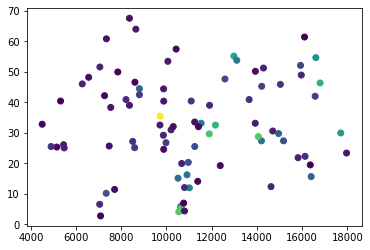

In [108]:
# with np.float64, seed 3
plt.scatter(feats[0][:, 0], feats[0][:,1], c = ry.values[:86])

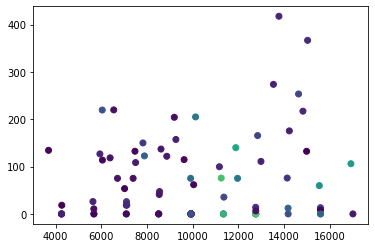

In [83]:
# with np uint 8, seed3
plt.scatter(n800[:,0], n800[:,1], c = ry.values[:86])

In [206]:
def extract_features_test(image, centroids, sigma):
    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()
    im_8=np.uint8(image)

    edged = cv2.Canny(im_8, 30, 200)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    im_blur = ndimage.gaussian_filter(cp.array(image), sigma=sigma, mode='constant',cval=0)
    
    im_blur_norm=im_blur*sigma*cp.sqrt(np.pi)

    im_sx = ndimage.sobel(im_blur_norm, axis=1, mode='reflect')
    im_sy = ndimage.sobel(im_blur_norm, axis=0, mode='reflect')
    im_sobel=np.hypot(im_sx, im_sy)

    feats = []
   
    for centroid in centroids:
        x, y = centroid[0], centroid[1]
        density = cp.nanmean(im_blur_norm[x-75: x+75, y-75: y+75])
        grad = cp.nanmean(im_sobel[x-75: x+75, y-75: y+75])
        feats.append([density.get(), grad.get()])

    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()

    feats = np.array(feats)
    return feats

In [207]:
pattern_dim = 40
threshold = 1/16

def generate_pattern(pattern_dim, threshold, seed):
    np.random.seed(seed)
    random_pattern = np.random.rand(pattern_dim, pattern_dim)
    binary_pattern = np.where(random_pattern < threshold, 1, 0)

    org_locs = np.argwhere(binary_pattern == 1)

    org_locs_scaled = org_locs*200+25
    centroids = []
    im = np.zeros((8000, 8000))

    for y, x in org_locs_scaled:
        im[y:y+150,x:x+150] = 255
        centroids.append((y+75, x+75))
    
    return im, centroids


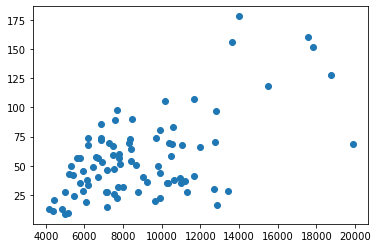

In [135]:
plt.scatter(feats[:, 0], feats[:,1])

In [208]:
forHeitor = []
for seed in [3, 4, 7, 8, 11, 12]:
    im, centroids = generate_pattern(pattern_dim, threshold, seed)
    seed_vec = [seed]*len(feats)
    subHeitor = [seed_vec, centroids]
    
    for sigma in [200, 400, 600, 800]:
        feats = extract_features_test(im, centroids, sigma)
        subHeitor.append(feats)
        
    forHeitor.append(subHeitor)

In [209]:
seeds = [item[0] for item in forHeitor]
centroids = [item[1] for item in forHeitor]


feats200 = [item[2] for item in forHeitor]
feats400 = [item[3] for item in forHeitor]
feats600 = [item[4] for item in forHeitor]
feats800 = [item[5] for item in forHeitor]

In [210]:
import itertools

seeds = list(itertools.chain.from_iterable(seeds))
centroids = list(itertools.chain.from_iterable(centroids))

In [211]:
pdvers = [pd.DataFrame(np.vstack(item)) for item in [feats200, feats400, feats600, feats800]]

In [214]:
centroids = np.array(centroids)
x, y = centroids[:, 0], centroids[:, 1]

In [215]:
df = pd.concat(pdvers, axis = 1)
df["seeds"] = seeds
df["cx"] = x
df["cy"] = y

In [216]:
df.head()

,0,1,0,1,0,1,0,1,seeds,cx,cy
0,8656.933030,112.218825,7597.341244,70.007968,7041.797754,44.197520,7265.171755,42.114888,3,100,1700
1,8656.933030,112.218825,7611.521379,67.579849,7140.335794,37.316788,7536.277455,38.268426,3,100,2100
2,7391.419336,80.107744,4215.056702,13.497684,4638.139568,35.613095,6278.532303,46.010267,3,100,3300
3,7590.690018,75.739903,6942.516611,95.255350,7384.879493,74.448795,8365.924466,67.548575,3,300,5300
4,7582.769376,76.460920,5505.440377,46.367691,5126.986000,42.229020,5316.481195,40.382193,3,500,7900


In [217]:
columns = ["density200", "grad200", "density400", "grad400","density600", "grad600","density800", "grad800", "seeds", "cx", "cy"]

In [218]:
df.columns = columns

In [219]:
df.head()

,density200,grad200,density400,grad400,density600,grad600,density800,grad800,seeds,cx,cy
0,8656.933030,112.218825,7597.341244,70.007968,7041.797754,44.197520,7265.171755,42.114888,3,100,1700
1,8656.933030,112.218825,7611.521379,67.579849,7140.335794,37.316788,7536.277455,38.268426,3,100,2100
2,7391.419336,80.107744,4215.056702,13.497684,4638.139568,35.613095,6278.532303,46.010267,3,100,3300
3,7590.690018,75.739903,6942.516611,95.255350,7384.879493,74.448795,8365.924466,67.548575,3,300,5300
4,7582.769376,76.460920,5505.440377,46.367691,5126.986000,42.229020,5316.481195,40.382193,3,500,7900


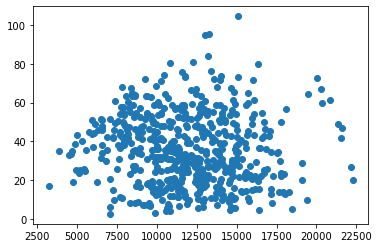

In [220]:
plt.scatter(df.density800.values, df.grad800.values)

In [221]:
df.to_csv("random_feats_dipole_df.csv", index=False)

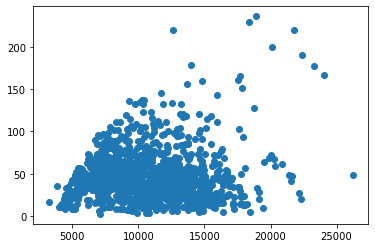

In [147]:
featstest = np.vstack(bigt)
plt.scatter(featstest[:, 0], featstest[:,1])

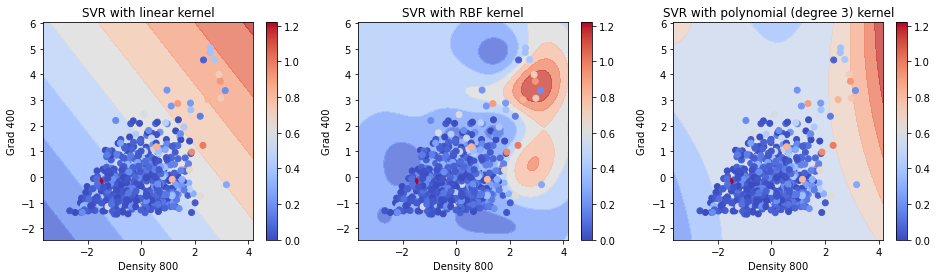

In [181]:
dfHeitorRandom = pd.read_csv("random_features_dipole.csv")
rX, ry = dfHeitorRandom.iloc[:, :-1], dfHeitorRandom.iloc[:, -1]
rxSub = rX[["density_800", "grad_400"]]
scaler = StandardScaler()
rxSubScale = scaler.fit_transform(rxSub)
x, y = rxSubScale[:, 0], rxSubScale[:, 1]

svc = SVR(kernel='linear').fit(rxSubScale, ry.ravel())
rbf_svc = SVR(kernel='rbf').fit(rxSubScale, ry.ravel())
poly_svc = SVR(kernel='poly').fit(rxSubScale, ry.ravel())
sig_svc = SVR(kernel='sigmoid').fit(rxSubScale, ry.ravel())


h = .01
x_min, x_max = x.min() - 1, x.max() + 1
y_min, y_max = y.min() - 1, y.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

titles = ['SVR with linear kernel',
          'SVR with RBF kernel',
          'SVR with polynomial (degree 3) kernel',
          'SVR with sigmoid kernel']

plt.figure(figsize=(16,4))
for i, regr in enumerate((svc, rbf_svc, poly_svc)):
    plt.subplot(1, 3, i + 1)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    Z = regr.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(x, y, c=ry.ravel(), cmap=plt.cm.coolwarm)
    plt.xlabel('Density 800')
    plt.ylabel('Grad 400')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.colorbar()
    plt.title(titles[i])

plt.show()

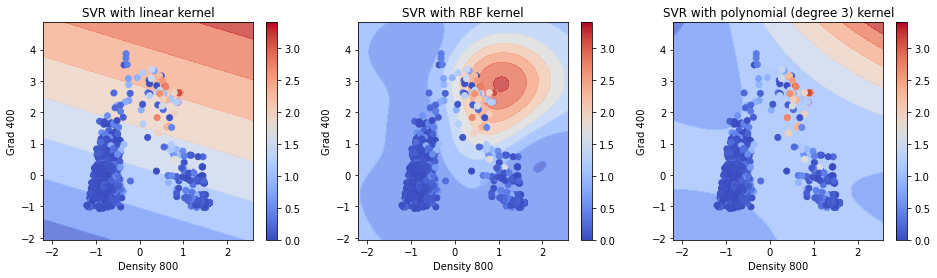

In [3]:
bX = pd.read_csv("dfXFilterHeitor.csv")

by = pd.read_csv("dfyFilterHeitor.csv").values

bxSub = bX[["density_400", "grad_400"]]
scaler = StandardScaler()
bxSubScale = scaler.fit_transform(bxSub)

x, y, z = bxSubScale[:, 0], bxSubScale[:, 1], by

svc = SVR(kernel='linear').fit(bxSubScale, by.ravel())
rbf_svc = SVR(kernel='rbf').fit(bxSubScale, by.ravel())
poly_svc = SVR(kernel='poly').fit(bxSubScale, by.ravel())
sig_svc = SVR(kernel='sigmoid').fit(bxSubScale, by.ravel())


h = .01
x_min, x_max = x.min() - 1, x.max() + 1
y_min, y_max = y.min() - 1, y.max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

titles = ['SVR with linear kernel',
          'SVR with RBF kernel',
          'SVR with polynomial (degree 3) kernel',
          'SVR with sigmoid kernel']

plt.figure(figsize=(16,4))
for i, regr in enumerate((svc, rbf_svc, poly_svc)):
    plt.subplot(1, 3, i + 1)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    Z = regr.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(x, y, c=by.ravel(), cmap=plt.cm.coolwarm)
    plt.xlabel('Density 800')
    plt.ylabel('Grad 400')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.colorbar()
    plt.title(titles[i])

plt.show()

# Generate Patterns

In [4]:
pattern_dim = 40
threshold = 1/16

def generate_pattern(pattern_dim, threshold, seed):
    np.random.seed(seed)
    random_pattern = np.random.rand(pattern_dim, pattern_dim)
    binary_pattern = np.where(random_pattern < threshold, 1, 0)

    org_locs = np.argwhere(binary_pattern == 1)

    org_locs_scaled = org_locs*200+25
    centroids = []
    im = np.zeros((8000, 8000))

    for y, x in org_locs_scaled:
        im[y:y+150,x:x+150] = 255
        centroids.append((y+75, x+75))
    
    return im, centroids

im, centroids = generate_pattern(pattern_dim, threshold, 3)

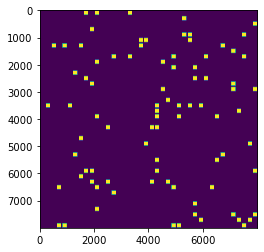

In [18]:
plt.imshow(im)

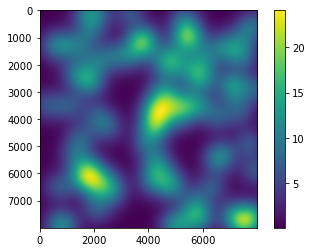

In [67]:
feats = extract_features(im, 400)

(array([10.,  6., 17., 17.,  8.,  8.,  6.,  7.,  4.,  3.]),
 array([ 4143.19352011,  5376.8016632 ,  6610.40980629,  7844.01794938,
         9077.62609247, 10311.23423557, 11544.84237866, 12778.45052175,
        14012.05866484, 15245.66680793, 16479.27495102]),
 <BarContainer object of 10 artists>)

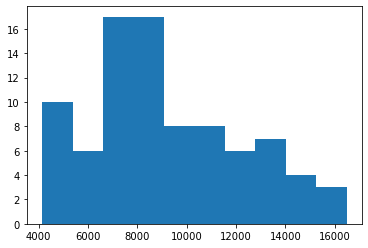

In [68]:
plt.hist(feats[:, 0])

(array([13., 11., 13., 13., 12.,  5.,  7.,  4.,  5.,  3.]),
 array([ 12.74164118,  25.13870618,  37.53577119,  49.9328362 ,
         62.32990121,  74.72696621,  87.12403122,  99.52109623,
        111.91816124, 124.31522624, 136.71229125]),
 <BarContainer object of 10 artists>)

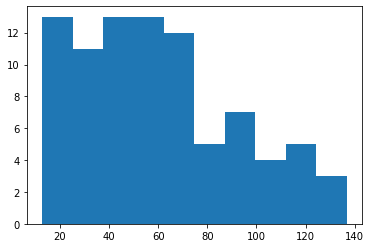

In [71]:
plt.hist(feats[:, 1])

In [4]:
dfHeitorRandom = pd.read_csv("random_features_dipole.csv")
rX, ry = dfHeitorRandom.iloc[:, :-1], dfHeitorRandom.iloc[:, -1]
rxSub = rX[["density_800", "grad_400"]]
scaler = StandardScaler()
rxSubScale = scaler.fit_transform(rxSub)
x, y = rxSubScale[:, 0], rxSubScale[:, 1]

#svc = SVR(kernel='linear').fit(rxSubScale, ry.ravel())
rbf_svc = SVR(kernel='rbf').fit(rxSubScale, ry.ravel())

(array([394.,  92.,  29.,  27.,   9.,   4.,   7.,   3.,   2.,   1.]),
 array([0.        , 0.12185011, 0.24370022, 0.36555034, 0.48740045,
        0.60925056, 0.73110067, 0.85295078, 0.9748009 , 1.09665101,
        1.21850112]),
 <BarContainer object of 10 artists>)

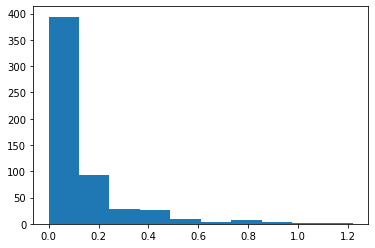

In [5]:
plt.hist(ry.ravel())

(array([  9.,  25.,  71., 109., 132., 109.,  70.,  30.,   7.,   6.]),
 array([-2.66731628, -2.08249791, -1.49767955, -0.91286118, -0.32804281,
         0.25677556,  0.84159392,  1.42641229,  2.01123066,  2.59604902,
         3.18086739]),
 <BarContainer object of 10 artists>)

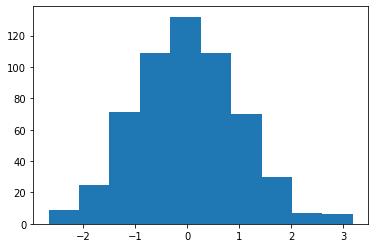

In [6]:
plt.hist(rxSubScale[:, 0])

(array([117., 174., 142.,  73.,  34.,  14.,   6.,   3.,   1.,   4.]),
 array([-1.44167865, -0.79410461, -0.14653057,  0.50104347,  1.1486175 ,
         1.79619154,  2.44376558,  3.09133962,  3.73891365,  4.38648769,
         5.03406173]),
 <BarContainer object of 10 artists>)

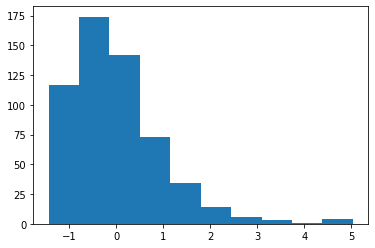

In [7]:
plt.hist(rxSubScale[:, 1])

(array([491.,  46.,  13.,  10.,   2.,   1.,   0.,   1.,   1.,   3.]),
 array([0.08470381, 0.14426886, 0.20383391, 0.26339897, 0.32296402,
        0.38252907, 0.44209412, 0.50165917, 0.56122422, 0.62078927,
        0.68035433]),
 <BarContainer object of 10 artists>)

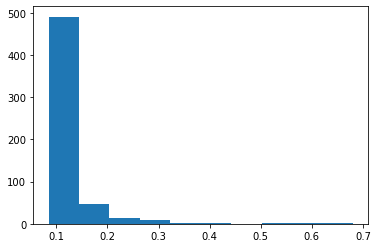

In [8]:
plt.hist(rbf_svc.predict(rxSubScale))

In [12]:
good_points = rxSubScale[rbf_svc.predict(rxSubScale) > 0.5]

In [13]:
good_points

array([[2.94854468, 3.7357674 ],
       [2.96854978, 3.07451646],
       [3.13629788, 3.37176038],
       [2.90295508, 3.99556773],
       [2.49122656, 3.01609379]])

In [88]:
im, centroids = generate_window(3, 0.5, 1000)

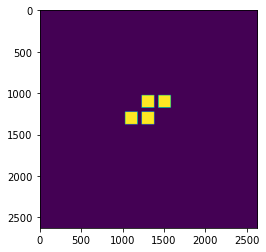

In [89]:
plt.imshow(im)

In [2]:
def extract_features(image, sigma):
    im = image.copy()
    mempool = cp.get_default_memory_pool()
    pinned_mempool = cp.get_default_pinned_memory_pool()
    im_8=np.uint8(im)
    #gray = cv2.cvtColor(im_8, cv2.COLOR_BGR2GRAY)
    # Find Canny edges
    edged = cv2.Canny(im_8, 30, 200)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    im_blur = ndimage.gaussian_filter(cp.array(im), sigma=sigma, mode='constant',cval=0)
    
    im_blur_norm=im_blur*sigma*cp.sqrt(np.pi)
    
    im_sx = ndimage.sobel(im_blur_norm, axis=1, mode='reflect')
    im_sy = ndimage.sobel(im_blur_norm, axis=0, mode='reflect')
    im_sobel=np.hypot(im_sx, im_sy)
    
    centroids = []
    feats = []
    #im_lap = ndimage.gaussian_laplace(im, sigma=sigma, mode='reflect')
    for jj in range(np.shape(contours)[0]):            
        im_zer = np.zeros( (im.shape[0],im.shape[1]) ) # create a single channel 200x200 pixel black image 
        filled_array = cv2.fillPoly(im_zer, pts =[contours[jj]], color=(255))
        obj = np.argwhere(filled_array == 255)
        #number_mat[ii,jj]=number

        density=cp.nanmean(im_blur_norm[obj[:,0],obj[:,1]])
        grad=cp.nanmean(im_sobel[obj[:,0],obj[:,1]])
        #lap=np.nanmean(im_lap[obj[:,0],obj[:,1]])
        
        M = cv2.moments(contours[jj])
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centroids.append(np.array([cX,cY]).reshape(-1,2))
        feats.append([density.get(), grad.get()])

    mempool.free_all_blocks()
    pinned_mempool.free_all_blocks()
    return np.array(feats)

In [3]:
def generate_window(window_size, p, local_radius):
    random_pattern = np.random.rand(window_size, window_size)
    binary_pattern = np.where(random_pattern < p, 1, 0)

    org_locs = np.argwhere(binary_pattern == 1)

    org_locs_scaled = org_locs*200+25+local_radius
    pattern_dim_scaled = window_size*200+25+2*local_radius
    
    centroids = []
    im = np.zeros((pattern_dim_scaled, pattern_dim_scaled))

    for y, x in org_locs_scaled:
        im[y:y+150,x:x+150] = 255
        centroids.append((y+75, x+75))
    
    return im, centroids

In [4]:
dfHeitorRandom = pd.read_csv("random_features_dipole.csv")
rX, ry = dfHeitorRandom.iloc[:, :-1], dfHeitorRandom.iloc[:, -1]
rxSub = rX[["density_800", "grad_400"]]
scaler = StandardScaler()
rxSubScale = scaler.fit_transform(rxSub)
x, y = rxSubScale[:, 0], rxSubScale[:, 1]
rbf_svc = SVR(kernel='rbf').fit(rxSubScale, ry.ravel())

windows = list(range(5, 9))
ps = np.linspace(0.1,.4, 5)

best_designs = []
for _ in tqdm(range(10)):
    for window in windows:
        for p in ps:
            im, centroids = generate_window(window, p, 1025)
            plt.show()
            if len(feats800) > 0 and len(feats400) > 0:
                density = feats800[:, 0]
                grad = feats400[:, 1]
                newX = np.hstack((density, grad)).reshape(-1, 2)
                newXScaled = scaler.transform(newX)
                preds = rbf_svc.predict(newXScaled)
                pred_min = np.min(preds)
                pred_mean = np.mean(preds)
                pred_max = np.max(preds)
                best_designs.append([im, window, p, newXScaled, pred_min, pred_mean, pred_max])
        
        

  0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]


NameError: name 'feats800' is not defined

In [ ]:
dfHeitorRandom = pd.read_csv("random_features_dipole.csv")
rX, ry = dfHeitorRandom.iloc[:, :-1], dfHeitorRandom.iloc[:, -1]
rxSub = rX[["density_800", "grad_400"]]
scaler = StandardScaler()
rxSubScale = scaler.fit_transform(rxSub)
x, y = rxSubScale[:, 0], rxSubScale[:, 1]
rbf_svc = SVR(kernel='rbf').fit(rxSubScale, ry.ravel())

windows = list(range(5, 9))
ps = np.linspace(0.1,.4, 5)

best_designs = []
for _ in tqdm(range(100)):
    im, centroids = generate_window(8, .3, 25)
    plt.show()
    feats800 = extract_features(im, 800)
    feats400 = extract_features(im, 400)
    if len(feats800) > 0 and len(feats400) > 0:
        density = feats800[:, 0]
        grad = feats400[:, 1]
        newX = np.hstack((density, grad)).reshape(-1, 2)
        newXScaled = scaler.transform(newX)
        preds = rbf_svc.predict(newXScaled)
        pred_min = np.min(preds)
        pred_mean = np.mean(preds)
        pred_max = np.max(preds)
        best_designs.append([im, c, newXScaled, pred_min, pred_mean, pred_max])
        
        